# Feature Engineering - FantaSanremo 2026

Questo notebook esplora e analizza le 40+ feature ingegnerizzate dalla pipeline ML di produzione.

**Principio chiave**: le feature sono costruite da `FeatureBuilder` e selezionate dalle funzioni
di `train.py`. Questo notebook **non reimplementa** la logica, ma la chiama e aggiunge visualizzazioni.

**Pipeline di produzione**:
- `FeatureBuilder.build_training_frame()` -> 40+ feature in 6 categorie
- `remove_redundant_features()` -> rimuove feature con correlazione > 0.95
- `select_features_adaptive()` -> seleziona ~21 feature con rapporto 5:1 samples/features

In [1]:
# Setup — imports da train.py e FeatureBuilder
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

from backend.ml.feature_builder import FeatureBuilder
from backend.ml.train import (
    normalize_targets,
    remove_redundant_features,
    select_features_adaptive,
)


In [2]:
# Caricamento dati con FeatureBuilder (stessa pipeline di train.py)
builder = FeatureBuilder()
sources = builder.load_sources()
full_df = builder.build_training_frame(sources)

splits = builder.split_by_years(
    full_df, builder.config.training_years, builder.config.validation_years
)
train_df = splits["train"]

feature_cols = builder.get_feature_columns(full_df)

print(f"Campioni totali: {len(full_df)}")
print(f"Campioni training: {len(train_df)}")
print(f"Feature disponibili: {len(feature_cols)}")
print(f"Anni training: {sorted(train_df['anno'].unique().tolist())}")


2026-02-09 14:45:36,946 - MLDataPreparation - INFO - Training years: [2020, 2021, 2022, 2024]
2026-02-09 14:45:36,946 - MLDataPreparation - INFO - Validation years: [2023, 2025]
2026-02-09 14:45:36,948 - MLDataPreparation - INFO - Loaded artisti_2026: 30 artists
2026-02-09 14:45:36,949 - MLDataPreparation - INFO - Loaded storico_unified
2026-02-09 14:45:36,949 - MLDataPreparation - INFO - Loaded biografico: 30 entries
2026-02-09 14:45:36,949 - MLDataPreparation - INFO - Loaded caratteristiche: 30 entries
2026-02-09 14:45:36,950 - MLDataPreparation - INFO - Loaded regolamento_2026
2026-02-09 14:45:36,951 - MLDataPreparation - INFO - Loaded classifiche_finali
2026-02-09 14:45:36,951 - MLDataPreparation - INFO - Loaded voti_stampa
2026-02-09 14:45:36,960 - MLDataPreparation - INFO - Built historical dataframe: 167 records, 131 unique artists
2026-02-09 14:45:36,964 - MLDataPreparation - INFO - Calculated 167 real scores from historical data


Campioni totali: 167
Campioni training: 108
Feature disponibili: 72
Anni training: [2020, 2021, 2022, 2024]


## 1. Tutte le feature disponibili (40+)

Le feature sono generate automaticamente da `FeatureBuilder._attach_static_features()` in 6 categorie:
historical, genre, biographical, regulatory, caratteristiche, archetypes.

In [3]:
# Tutte le feature con statistiche base
print(f"Feature totali: {len(feature_cols)}\n")

# Classifica per categoria (basata su prefisso/nome)
categories = {
    "Historical": [c for c in feature_cols if c.startswith(("pos_", "hist_", "partecipaz"))
                   or c in ("momentum", "consistency", "peak_position", "trend_slope")],
    "Genre": [c for c in feature_cols if c.startswith("genre_")],
    "Biographical": [c for c in feature_cols if c.startswith(("age_", "gen_", "is_"))
                     and not c.startswith("genre_")],
    "Regulatory": [c for c in feature_cols if c.startswith(("bonus_", "malus_", "reg_", "net_"))],
    "Caratteristiche": [c for c in feature_cols if c.startswith(("carisma", "viral", "stage_"))
                        or "charisma" in c or "viralita" in c],
    "Archetypes": [c for c in feature_cols if c.startswith("arch_")],
    "Debuttanti": [c for c in feature_cols if "debuttant" in c.lower() or c.startswith("proxy_")],
}

# Feature non categorizzate
categorized = set()
for feats in categories.values():
    categorized.update(feats)
categories["Other"] = [c for c in feature_cols if c not in categorized]

for cat, feats in categories.items():
    if feats:
        print(f"\n{cat} ({len(feats)}):")
        for f in sorted(feats):
            print(f"  - {f}")

Feature totali: 72


Genre (7):
  - genre_avg_performance
  - genre_mainstream_pop
  - genre_rap_urban
  - genre_rock_indie
  - genre_trend
  - genre_veteran
  - genre_win_rate

Biographical (11):
  - age_genre_mainstream_pop
  - age_genre_rap_urban
  - age_genre_rock_indie
  - age_genre_veteran
  - age_viral_interaction
  - gen_x
  - gen_z
  - is_debuttante_x
  - is_debuttante_y
  - is_recent
  - is_veteran

Regulatory (2):
  - bonus_count
  - bonus_experience_interaction

Caratteristiche (5):
  - viral_genre_mainstream_pop
  - viral_genre_rap_urban
  - viral_genre_rock_indie
  - viral_genre_veteran
  - viral_potential

Debuttanti (4):
  - DEBUTTANTE_POTENTIAL
  - experience_debuttante_potential
  - is_debuttante_x
  - is_debuttante_y

Other (45):
  - INDIE_DARLING
  - LEGENDARY_STATUS
  - POP_MAINSTREAM
  - RAP_TRAP_STAR
  - VETERAN_PERFORMER
  - VIRAL_PHENOMENON
  - ad_personam_bonus_count_x
  - ad_personam_bonus_count_y
  - ad_personam_bonus_points_x
  - ad_personam_bonus_points_y


## 2. Rimozione feature ridondanti

Usa `remove_redundant_features()` da `train.py` per trovare e rimuovere feature con
correlazione > 0.95. Visualizziamo la matrice di correlazione prima e dopo.

Feature prima: 72
Feature ridondanti rimosse (22):
  - viral_genre_rock_indie
  - median_position
  - viral_genre_rap_urban
  - social_followers_score
  - consistency_score
  - momentum_score
  - longevity_bonus
  - recent_avg
  - ad_personam_bonus_count_y
  - age_genre_veteran
  - career_genre_mainstream_pop
  - viral_genre_veteran
  - age_genre_rock_indie
  - experience_score
  - ad_personam_bonus_points_x
  - ad_personam_bonus_points_y
  - peak_performance
  - is_debuttante_x
  - age_genre_rap_urban
  - has_ad_personam_bonus
  - best_position
  - volatility_index
Feature dopo: 50


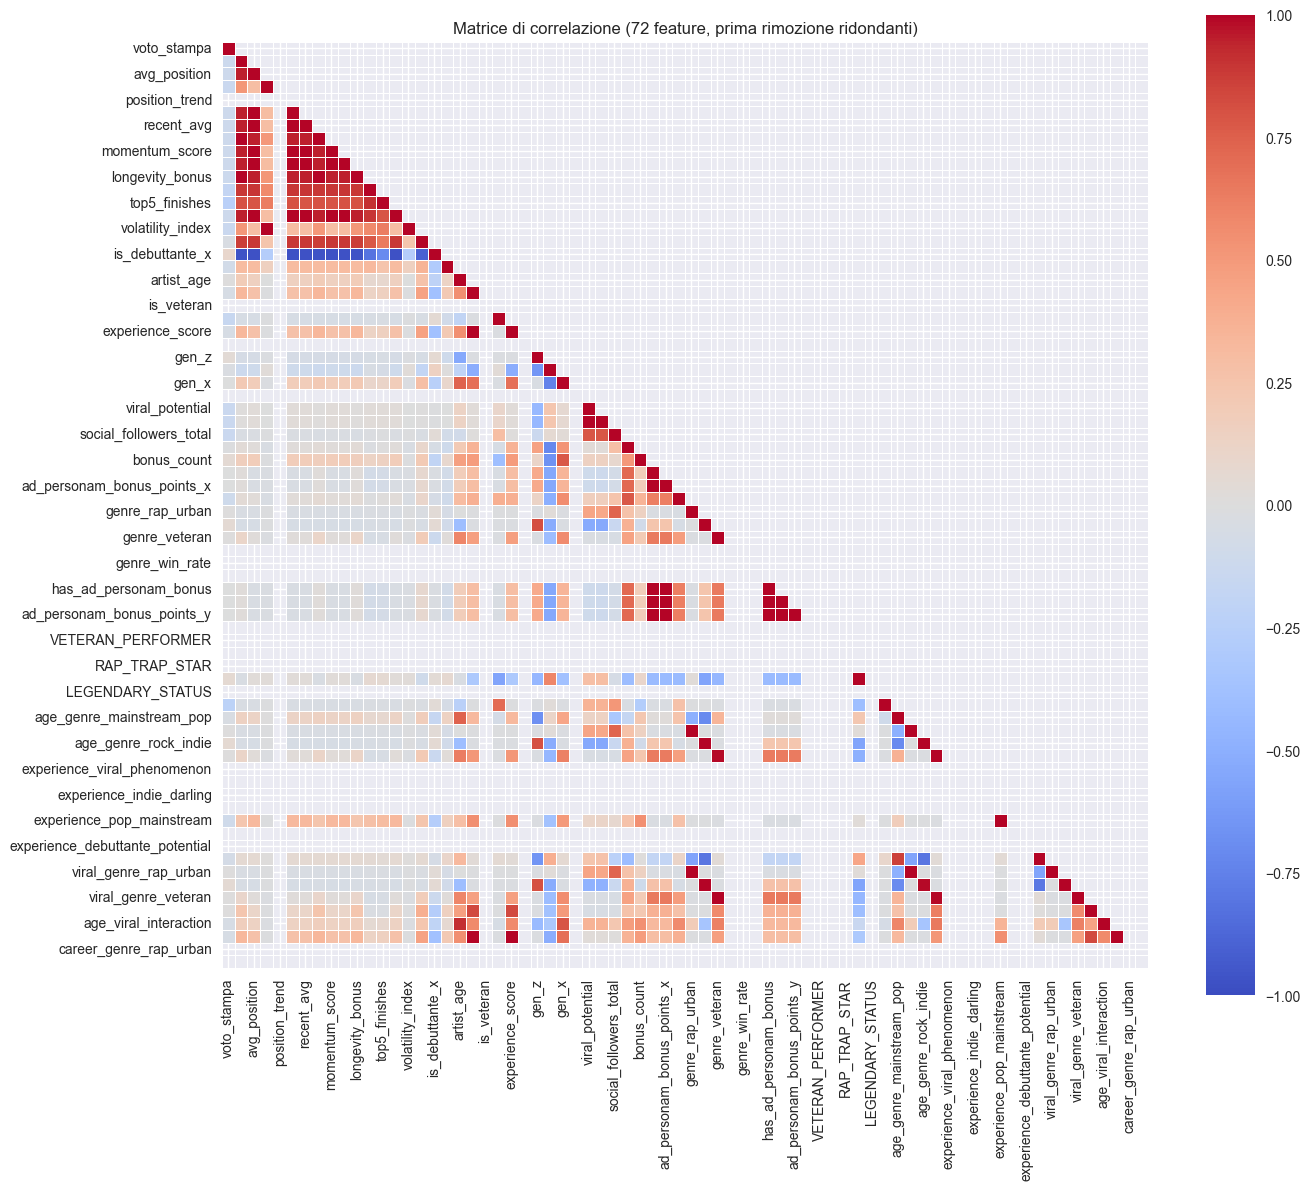

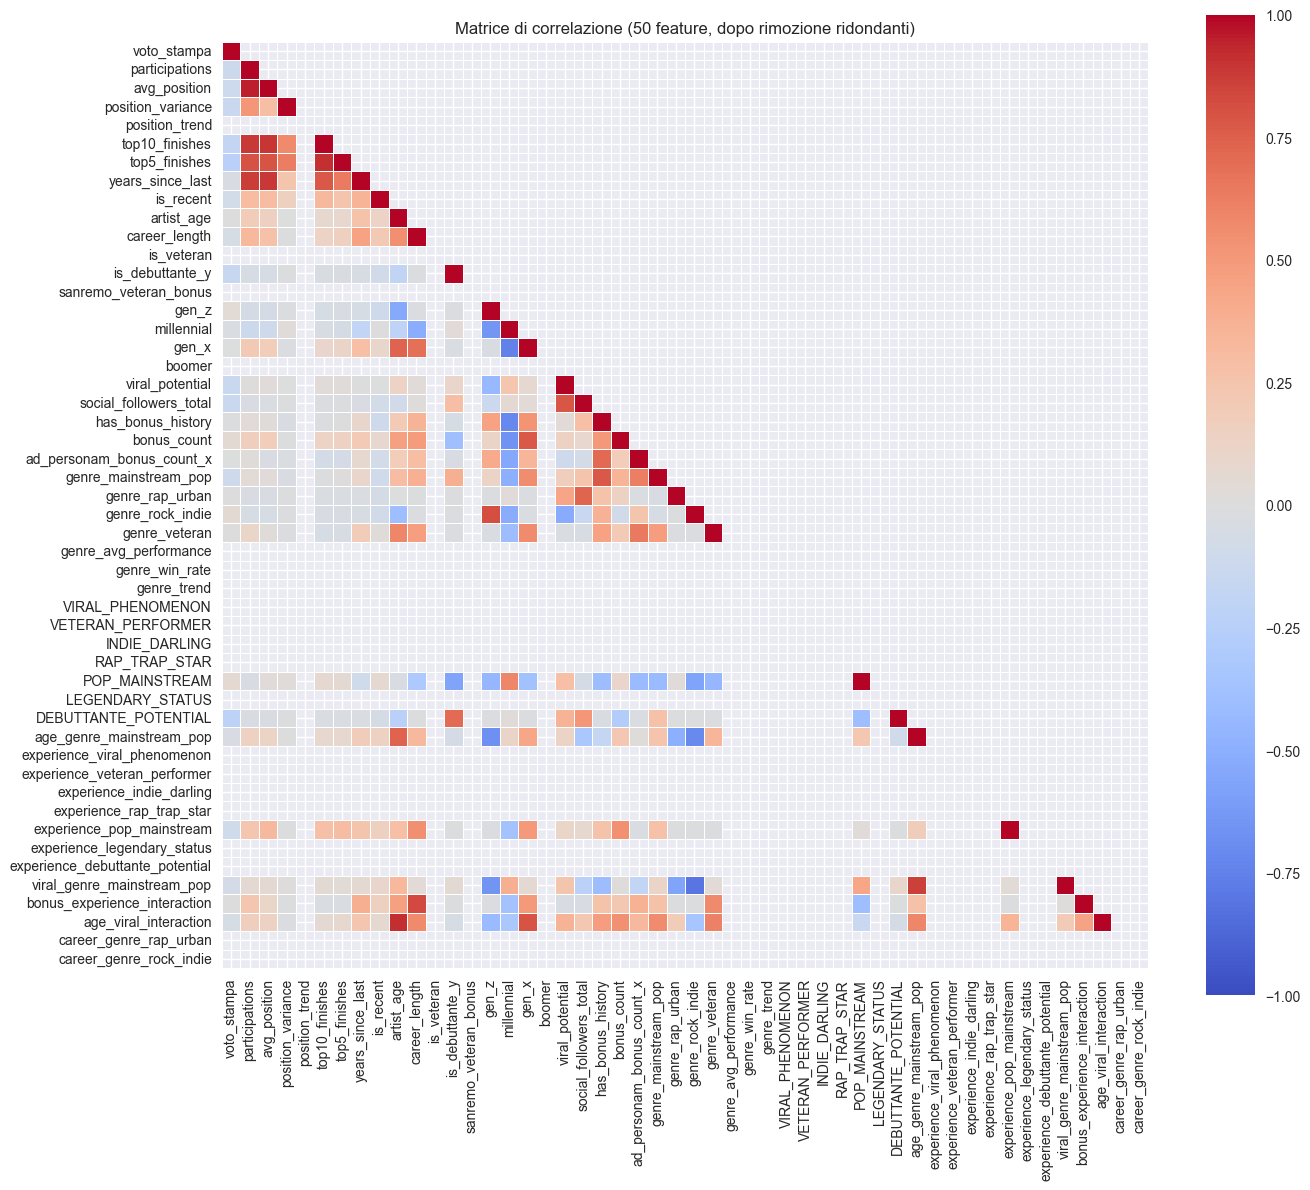

In [4]:
# Rimozione ridondanti — stessa funzione di train.py
X_raw = train_df[feature_cols].fillna(0)
feature_cols_orig = [c for c in feature_cols]
# Matrice di correlazione delle feature rimanenti
fig, ax = plt.subplots(figsize=(14, 12))
corr = X_raw.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax, fmt=".1f",
            annot=len(feature_cols_orig) <= 25)
ax.set_title(f"Matrice di correlazione ({len(feature_cols_orig)} feature, prima rimozione ridondanti)")
plt.tight_layout()


redundant = remove_redundant_features(X_raw, threshold=0.95)
feature_cols_clean = [c for c in feature_cols if c not in redundant]

print(f"Feature prima: {len(feature_cols)}")
print(f"Feature ridondanti rimosse ({len(redundant)}):")
for r in redundant:
    print(f"  - {r}")
print(f"Feature dopo: {len(feature_cols_clean)}")

# Matrice di correlazione delle feature rimanenti
fig, ax = plt.subplots(figsize=(14, 12))
corr = X_raw[feature_cols_clean].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax, fmt=".1f",
            annot=len(feature_cols_clean) <= 25)
ax.set_title(f"Matrice di correlazione ({len(feature_cols_clean)} feature, dopo rimozione ridondanti)")
plt.tight_layout()


## 3. Selezione adattiva feature

Usa `select_features_adaptive()` da `train.py` per selezionare le feature ottimali
con rapporto 5:1 (campioni / feature). Con 108 campioni -> max ~21 feature.

In [5]:
# Selezione adattiva — stessa funzione di train.py
# Prima normalizza i target (come fa train.py)
train_norm, year_stats = normalize_targets(train_df)
y = train_norm["punteggio_reale"]

selected_features = select_features_adaptive(X_raw, y, feature_cols_clean, ratio=5)

print(f"Feature dopo selezione adattiva: {len(selected_features)}")
print(f"Rapporto campioni/feature: {len(train_df)}/{len(selected_features)} "
      f"= {len(train_df)/len(selected_features):.1f}:1")
print(f"\nFeature selezionate:")
for i, f in enumerate(selected_features, 1):
    print(f"  {i:2d}. {f}")


Feature dopo selezione adattiva: 21
Rapporto campioni/feature: 108/21 = 5.1:1

Feature selezionate:
   1. voto_stampa
   2. participations
   3. avg_position
   4. position_variance
   5. top10_finishes
   6. years_since_last
   7. artist_age
   8. career_length
   9. is_debuttante_y
  10. millennial
  11. gen_x
  12. viral_potential
  13. has_bonus_history
  14. bonus_count
  15. genre_mainstream_pop
  16. genre_rap_urban
  17. POP_MAINSTREAM
  18. DEBUTTANTE_POTENTIAL
  19. age_genre_mainstream_pop
  20. experience_pop_mainstream
  21. age_viral_interaction


## 4. Analisi feature selezionate

Correlazione con il target, distribuzione valori e importanza relativa delle feature finali.

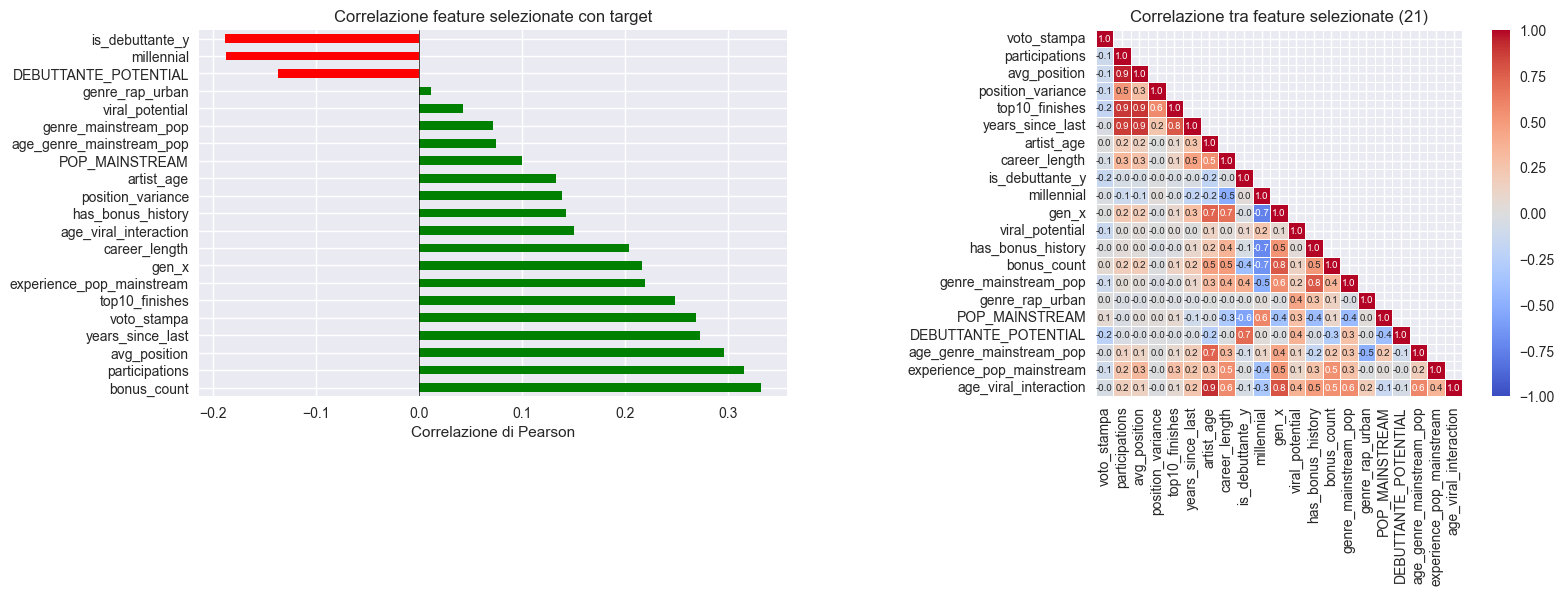

In [6]:
# Correlazione feature selezionate con target
X_selected = train_df[selected_features].fillna(0)
correlations = X_selected.corrwith(train_df["punteggio_reale"]).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart correlazioni
colors = ["green" if v > 0 else "red" for v in correlations.values]
correlations.plot(kind="barh", ax=axes[0], color=colors)
axes[0].set_title("Correlazione feature selezionate con target")
axes[0].set_xlabel("Correlazione di Pearson")
axes[0].axvline(x=0, color="black", linewidth=0.5)

# Matrice di correlazione feature selezionate
corr_sel = X_selected.corr()
mask_sel = np.triu(np.ones_like(corr_sel, dtype=bool), k=1)
sns.heatmap(corr_sel, mask=mask_sel, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=axes[1], annot=True, fmt=".1f",
            annot_kws={"size": 7})
axes[1].set_title(f"Correlazione tra feature selezionate ({len(selected_features)})")

plt.tight_layout()


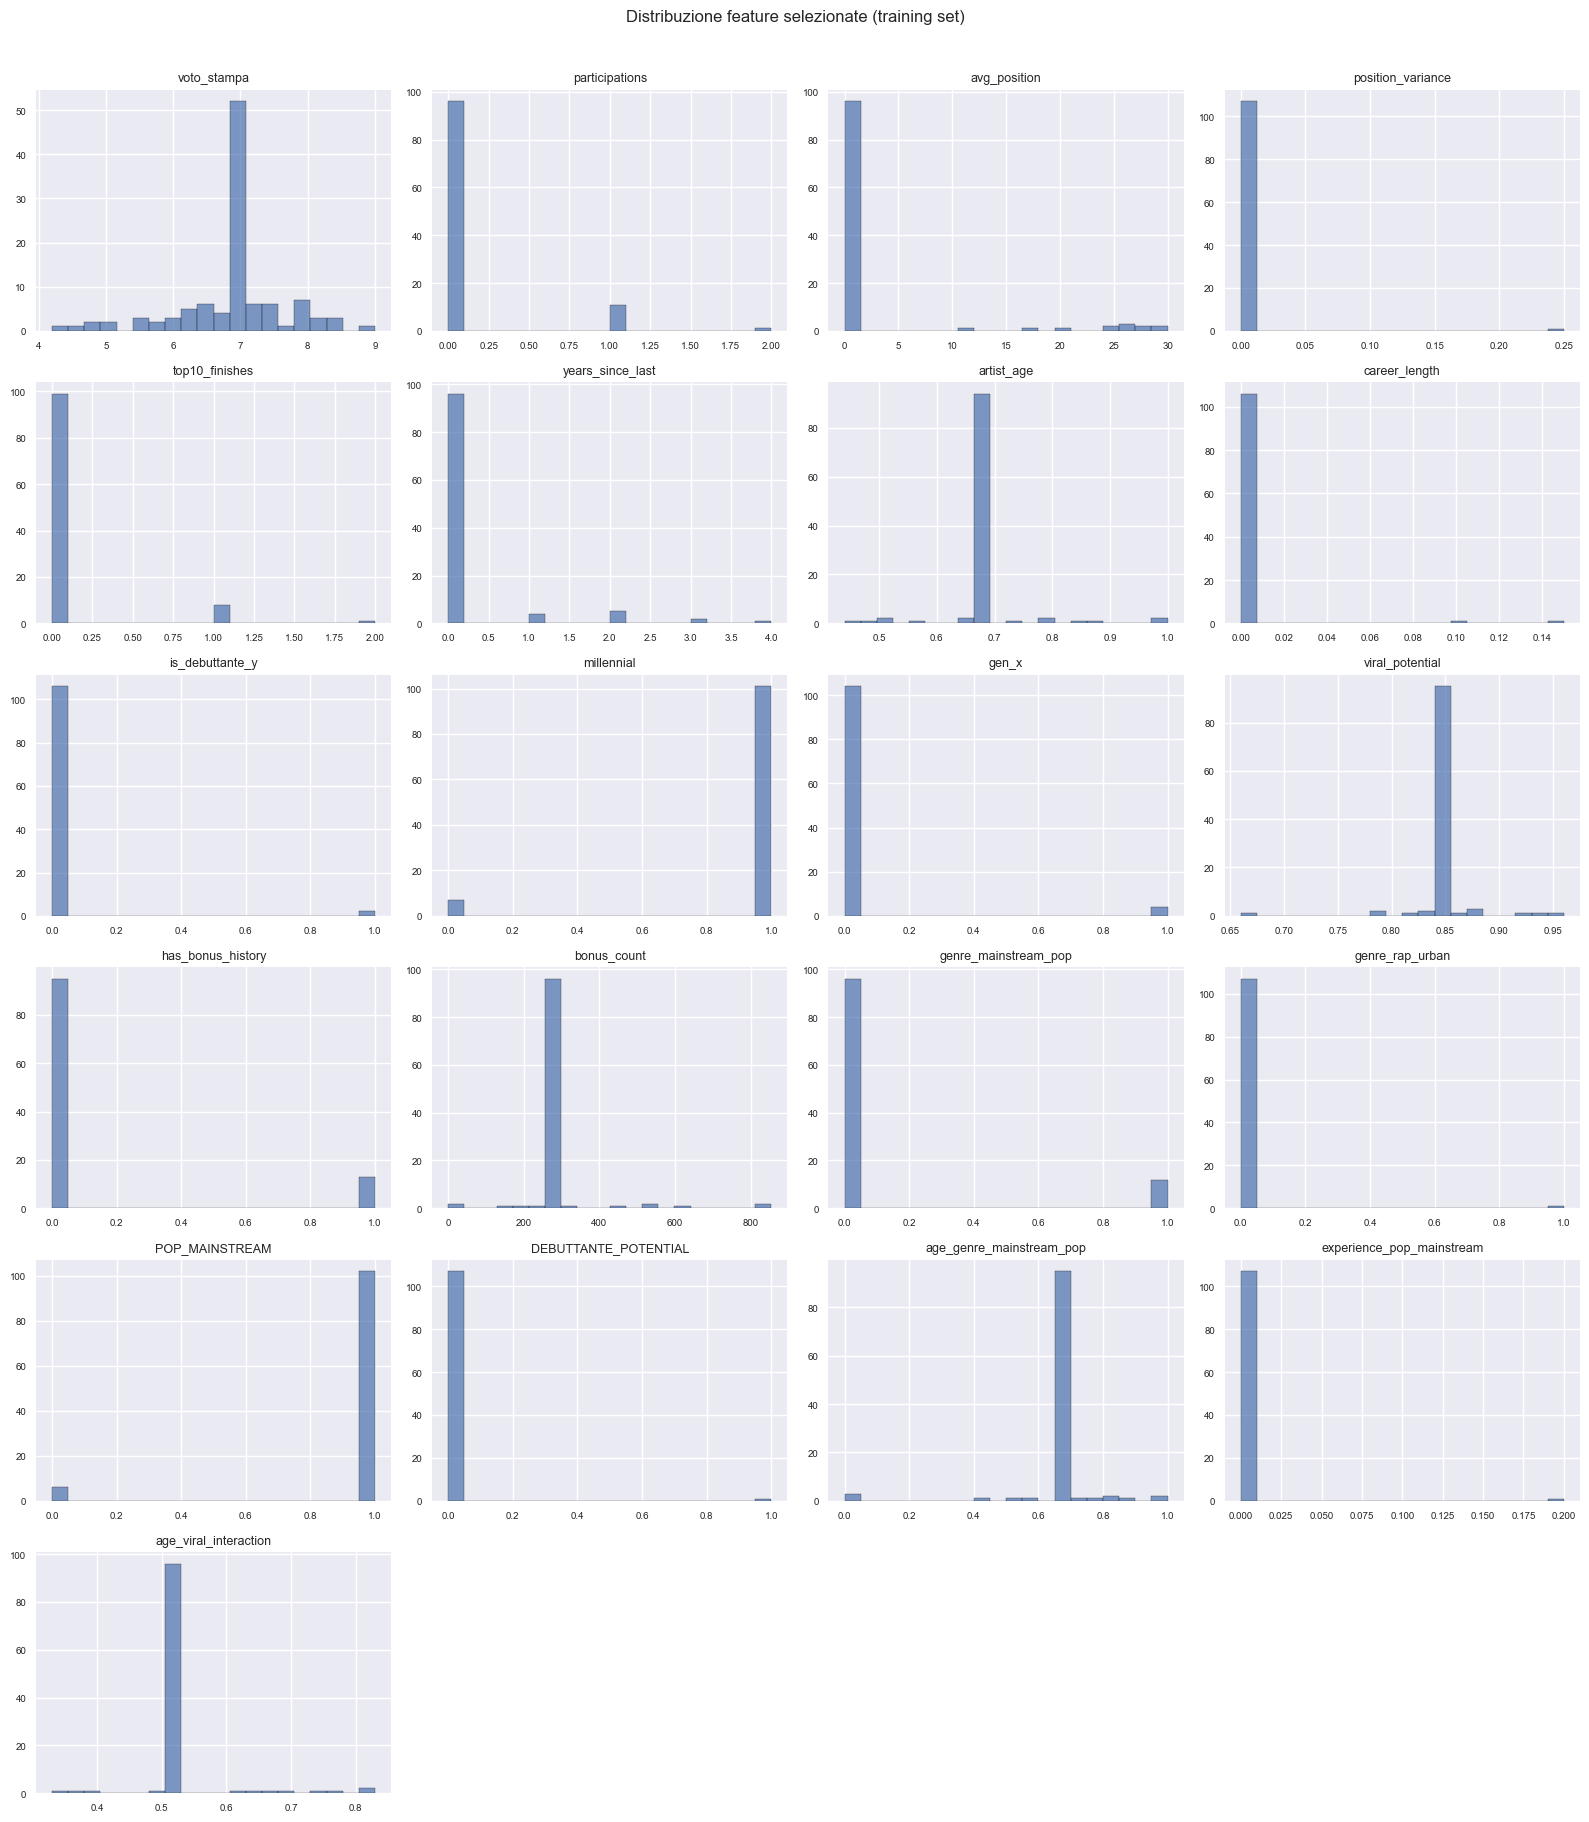

In [7]:
# Distribuzione delle feature selezionate
n_feats = len(selected_features)
n_cols = 4
n_rows = (n_feats + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes = axes.flatten()

for i, feat in enumerate(selected_features):
    axes[i].hist(train_df[feat].dropna(), bins=20, edgecolor="black", alpha=0.7)
    axes[i].set_title(feat, fontsize=9)
    axes[i].tick_params(labelsize=7)

# Nascondi assi vuoti
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Distribuzione feature selezionate (training set)", fontsize=12, y=1.01)
plt.tight_layout()
